## **[문제 1] Fashion	MNIST	데이터 정규화를 위한 Mean과	Std 값 찾기**

In [1]:
import os
from pathlib import Path
from datetime import datetime
import torch
import wandb
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import transforms

In [2]:
BASE_PATH = Path.cwd().parent # C:\Users\sjw99\git\link_dl
print(BASE_PATH)

C:\Users\sjw99\git\link_dl


In [3]:
import sys

sys.path.append(BASE_PATH)

In [4]:
from _01_code._99_common_utils.utils import get_num_cpu_cores, is_linux, is_windows
from _01_code._99_common_utils.early_stopping import EarlyStopping
from _01_code._99_common_utils.utils import strfdelta
from _01_code._09_fcn_best_practice.e_arg_parser import get_parser

CURRENT_FILE_PATH = Path.cwd()
CHECKPOINT_FILE_PATH = CURRENT_FILE_PATH / "checkpoints"
CHECKPOINT_FILE_PATH.mkdir(parents=True, exist_ok=True)

In [5]:
# mean, std 계산
def get_fashion_mnist_mean_std():
    data_path = os.path.join(BASE_PATH, "_00_data", "j_fashion_mnist")

    f_mnist_raw = datasets.FashionMNIST(data_path, train=True, download=True, transform=transforms.ToTensor())
    loader = DataLoader(f_mnist_raw, batch_size=len(f_mnist_raw))

    imgs, _ = next(iter(loader))
    print("Total Sample Shape: ", imgs.shape) # torch.Size([60000, 1, 28, 28])

    mean = imgs.mean().item()
    std = imgs.std().item()

    return mean, std

In [6]:
mean, std = get_fashion_mnist_mean_std()
print(f'mean = {mean:.4f}, std = {std:.4f}')

Total Sample Shape:  torch.Size([60000, 1, 28, 28])
mean = 0.2860, std = 0.3530


In [7]:
# train, validation
def get_fashion_mnist_data(mean=0.0, std=1.0):
    data_path = os.path.join(BASE_PATH, "_00_data", "j_fashion_mnist")

    # augmentation의 효과가 사실상 없어서 폐기
    # raw_train = datasets.FashionMNIST(data_path, train=True, download=True)
    # train_idx, val_idx = torch.utils.data.random_split(
    #     range(len(raw_train)), [55_000, 5_000]
    # )
    #
    # train_raw = datasets.FashionMNIST(data_path, train=True, download=False)
    # val_raw   = datasets.FashionMNIST(data_path, train=True, download=False)
    #
    # train_transform = transforms.Compose([
    #     transforms.ToTensor(),
    #     transforms.Normalize(mean=mean, std=std),
    # ])
    #
    # val_transform = transforms.Compose([
    #     transforms.ToTensor(),
    #     transforms.Normalize(mean=mean, std=std),
    # ])
    #  transform를 train, val, test 모두 동일하게 적용하기로 결론
    # 밖에서 transform 생성해 동일하게 적용

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

    raw_dataset = datasets.FashionMNIST(data_path, train=True, download=True, transform=transform)
    f_mnist_train, f_mnist_validation = random_split(raw_dataset, [55_000, 5_000])

    num_data_loading_workers = get_num_cpu_cores() if is_linux() or is_windows() else 0
    print("Number of Data Loading Workers:", num_data_loading_workers)

    train_data_loader = DataLoader(
        dataset=f_mnist_train, batch_size=wandb.config.batch_size, shuffle=True,
        pin_memory=True, num_workers=num_data_loading_workers
    )

    validation_data_loader = DataLoader(
        dataset=f_mnist_validation, batch_size=wandb.config.batch_size,
        pin_memory=True, num_workers=num_data_loading_workers
    )

    return train_data_loader, validation_data_loader

In [8]:
# test
def get_fashion_mnist_test_data(mean=0.0, std=1.0):
    data_path = os.path.join(BASE_PATH, "_00_data", "j_fashion_mnist")

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

    f_mnist_test = datasets.FashionMNIST(data_path, train=False, download=True, transform=transform)

    print("Num Test Samples: ", len(f_mnist_test))
    print("Sample Shape: ", f_mnist_test[0][0].shape)  # torch.Size([1, 28, 28])

    test_data_loader = DataLoader(dataset=f_mnist_test, batch_size=len(f_mnist_test))


    return test_data_loader

## **[문제 2] Fashion MNIST 데이터에 대하여 CNN 학습시키기**

 ### **[Fashion-MNIST Classification을 위한 CNN 모델 설계 요약]**

#### **데이터 특징**
- 1채널(흑백) 28×28 **저해상도 이미지**
- 질감·외곽선 등 **기본 패턴이 주요 정보**

#### **목표**
- 작은 데이터셋에서 **과적합을 억제**하면서
  **94~95% 수준의 정확도 확보**

---

### **설계 의도**

#### -**Block1: Conv(32) → Conv(32)**
- 같은 크기에서 두 번의 3×3 연산으로
  **기본적인 패턴을 충분히 추출**

#### -**Block2: Conv(64) + MaxPool**
- **28 → 14**로 크기를 줄여 **핵심 패턴을 남김**
- 64채널로 확장하여 **더 다양한 형태를 처리**

#### -**Block3: Conv(128)**
- 이전보다 **더 복잡한 패턴을 추출**

#### -**FC Block: Flatten → 512 → 128 → 10**
- **Flatten → 512**: 특징을 크게 잃지 않는 선에서 압축
- **512 → 128**: 표현력 유지하며 차원 축소
- **128 → 10**: 10개 클래스에 대한 최종 분류

---

### **Dropout 사용 이유**

- **초반 Dropout(0.25)**
  작은 데이터셋에서 발생하는 **빠른 과적합을 초기에 억제**

- **FC Dropout(0.5)**
  fc layer에서 과적합 영향이 크므로
  **dropout으로 일반화 성능 향상**

In [9]:
# 모델, 학습 함수 정의
# wandb 설정
# 데이터, 모델, loss, optim 가져오기
# 추가 고려사항 >> 규제화, 배치 정규화 + 전처리(증강) 실험
# 학습

# 모델 정의
def get_cnn_model():
  class MyModel(nn.Module):
    def __init__(self, in_channels, n_output):
      super().__init__()


      self.model = nn.Sequential(
        # block1
        # 입력: B x 1 x 28 x 28
        nn.Conv2d(1, 32, 3, padding=1),
        # 출력: B x 32 x 28 x 28
        nn.BatchNorm2d(32),
        nn.ReLU(),

        nn.Conv2d(32, 32, 3, padding=1),
        # 출력: B x 32 x 28 x 28
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Dropout2d(0.25),

        # block2
        nn.Conv2d(32, 64, 3, padding=1),
        # 출력: B x 64 x 28 x 28
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        # 출력: B x 64 x 14 x 14
        nn.Dropout(0.25),

        # block3
        nn.Conv2d(64, 128, 3, padding=1),
        # 출력: B x 128 x 14 x 14
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Dropout(0.25),

        nn.Flatten(),
        # 출력: B x (128*14*14) = B x 25088

        nn.Linear(128*14*14, 512),
        # 출력: B x 512
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Dropout(0.5),

        nn.Linear(512, 128),
        # 출력: B x 128
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Dropout(0.5),

        nn.Linear(128, 10)
        # 출력: B x 10
      )

    def forward(self, x):
      x = self.model(x)
      return x

  # 1 * 28 * 28
  my_model = MyModel(in_channels=1, n_output=10)

  return my_model

In [10]:
class ClassificationTrainer:
  def __init__(
    self, project_name, model, optimizer, train_data_loader, validation_data_loader, run_time_str, wandb, device, checkpoint_file_path
  ):
    self.project_name = project_name
    self.model = model
    self.optimizer = optimizer
    self.train_data_loader = train_data_loader
    self.validation_data_loader = validation_data_loader
    self.run_time_str = run_time_str
    self.wandb = wandb
    self.device = device
    self.checkpoint_file_path = checkpoint_file_path

    # Use a built-in loss function
    self.loss_fn = nn.CrossEntropyLoss()

  def do_train(self):
    self.model.train()  # Will be explained at 'Diverse Techniques' section

    loss_train = 0.0
    num_corrects_train = 0
    num_trained_samples = 0
    num_trains = 0

    for train_batch in self.train_data_loader:
      # input_train.shape: torch.Size([55000, 1, 28, 28]),  target_train.shape: torch.Size([55000])
      input_train, target_train = train_batch
      input_train = input_train.to(device=self.device)
      target_train = target_train.to(device=self.device)

      output_train = self.model(input_train)
      loss = self.loss_fn(output_train, target_train)
      loss_train += loss.item()

      predicted_train = torch.argmax(output_train, dim=-1)

      num_corrects_train += torch.sum(torch.eq(predicted_train, target_train)).item()

      num_trained_samples += len(input_train)
      num_trains += 1

      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

    train_loss = loss_train / num_trains
    train_accuracy = 100.0 * num_corrects_train / num_trained_samples

    return train_loss, train_accuracy

  def do_validation(self):
    self.model.eval()   # Explained at 'Diverse Techniques' section

    loss_validation = 0.0
    num_corrects_validation = 0
    num_validated_samples = 0
    num_validations = 0

    with torch.no_grad():
      for validation_batch in self.validation_data_loader:
        # input_train.shape: torch.Size([5000, 1, 28, 28]),  target_train.shape: torch.Size([5000])
        input_validation, target_validation = validation_batch
        input_validation = input_validation.to(device=self.device)
        target_validation = target_validation.to(device=self.device)

        output_validation = self.model(input_validation)
        loss_validation += self.loss_fn(output_validation, target_validation).item()

        predicted_validation = torch.argmax(output_validation, dim=1)
        num_corrects_validation += torch.sum(torch.eq(predicted_validation, target_validation)).item()

        num_validated_samples += len(input_validation)
        num_validations += 1

    validation_loss = loss_validation / num_validations
    validation_accuracy = 100.0 * num_corrects_validation / num_validated_samples

    return validation_loss, validation_accuracy

  def train_loop(self):
    early_stopping = EarlyStopping(
      patience=self.wandb.config.early_stop_patience,
      delta=self.wandb.config.early_stop_delta,
      project_name=self.project_name,
      checkpoint_file_path=self.checkpoint_file_path,
      run_time_str=self.run_time_str
    )
    n_epochs = self.wandb.config.epochs
    training_start_time = datetime.now()

    for epoch in range(1, n_epochs + 1):
      train_loss, train_accuracy = self.do_train()

      if epoch == 1 or epoch % self.wandb.config.validation_intervals == 0:
        validation_loss, validation_accuracy = self.do_validation()

        elapsed_time = datetime.now() - training_start_time
        epoch_per_second = 0 if elapsed_time.seconds == 0 else epoch / elapsed_time.seconds

        message, early_stop = early_stopping.check_and_save(validation_loss, self.model)

        print(
          f"[Epoch {epoch:>3}] "
          f"T_loss: {train_loss:7.5f}, "
          f"T_accuracy: {train_accuracy:6.4f} | "
          f"V_loss: {validation_loss:7.5f}, "
          f"V_accuracy: {validation_accuracy:6.4f} | "
          f"{message} | "
          f"T_time: {strfdelta(elapsed_time, '%H:%M:%S')}, "
          f"T_speed: {epoch_per_second:4.3f}"
        )

        self.wandb.log({
          "Epoch": epoch,
          "Training loss": train_loss,
          "Training accuracy (%)": train_accuracy,
          "Validation loss": validation_loss,
          "Validation accuracy (%)": validation_accuracy,
          "Training speed (epochs/sec.)": epoch_per_second,
        })

        if early_stop:
          break

    elapsed_time = datetime.now() - training_start_time
    print(f"Final training time: {strfdelta(elapsed_time, '%H:%M:%S')}")


In [11]:
class ClassificationTester:
  def __init__(self, project_name, model, test_data_loader, checkpoint_file_path):
    self.project_name = project_name
    self.model = model
    self.test_data_loader = test_data_loader
    self.latest_file_path = os.path.join(
      checkpoint_file_path, f"{project_name}_checkpoint_latest.pt"
    )

    print("MODEL FILE: {0}".format(self.latest_file_path))

    self.model.load_state_dict(torch.load(self.latest_file_path, map_location=torch.device('cpu')))

  def test(self):
    self.model.eval()    # Explained at 'Diverse Techniques' section

    num_corrects_test = 0
    num_tested_samples = 0

    with torch.no_grad():
      for test_batch in self.test_data_loader:
        input_test, target_test = test_batch

        output_test = self.model(input_test)

        predicted_test = torch.argmax(output_test, dim=-1)
        num_corrects_test += torch.sum(torch.eq(predicted_test, target_test))

        num_tested_samples += len(input_test)

      test_accuracy = 100.0 * num_corrects_test / num_tested_samples

    print(f"TEST RESULTS: {test_accuracy:6.3f}%")

  def test_single(self, input_test):
    self.model.eval()    # Explained at 'Diverse Techniques' section

    with torch.no_grad():
      output_test = self.model(input_test)
      predicted_test = torch.argmax(output_test, dim=-1)

    return predicted_test.item()


In [12]:
parser = get_parser()
args = parser.parse_args(args=[])   # Jupyter용 파싱

# wandb config
config = {
    'epochs': 15,
    'batch_size': 128,
    'learning_rate': 0.001,
    'validation_intervals': 1,
    'early_stop_patience': 5,
    'early_stop_delta': 0.0,
    'wandb': True
}

run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')
# name = "{0}_{1}".format(optimizer_names[args.optimizer], run_time_str)

project_name = "fashion-mnist-cnn"
wandb.init(
    mode = "online",
    project = project_name,
    notes = "Fashion-MNIST CNN training",
    tags = ["cnn", "fashion-mnist", "baseline"],
    config = config
)
print(args)
print(wandb.config)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on device {device}.")

# 데이터셋 준비
train_data_loader, validation_data_loader = get_fashion_mnist_data(mean, std)

# 모델 준비
model = get_cnn_model()
model.to(device)

from torchinfo import summary
summary(
    model,
    input_size=(1, 1, 28, 28),
    col_names=["kernel_size", "input_size", "output_size", "num_params"]
)

# 옵티마이져 준비(weight decay x)
optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate)

# train
classification_trainer = ClassificationTrainer(
project_name, model, optimizer, train_data_loader, validation_data_loader, run_time_str, wandb, device, CHECKPOINT_FILE_PATH
)
classification_trainer.train_loop()

wandb.finish()

wandb: Currently logged in as: jwdam (jwdam-korea-university-of-technology-and-education) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Namespace(wandb=False, batch_size=2048, epochs=10000, learning_rate=0.001, validation_intervals=10, early_stop_patience=10, early_stop_delta=1e-05)
{'epochs': 15, 'batch_size': 128, 'learning_rate': 0.001, 'validation_intervals': 1, 'early_stop_patience': 5, 'early_stop_delta': 0, 'wandb': True}
Training on device cuda.
Number of Data Loading Workers: 16
[Epoch   1] T_loss: 0.46172, T_accuracy: 84.7491 | V_loss: 0.25456, V_accuracy: 90.3600 | Early stopping is stated! | T_time: 00:00:58, T_speed: 0.017
[Epoch   2] T_loss: 0.28636, T_accuracy: 89.9036 | V_loss: 0.20855, V_accuracy: 91.9200 | V_loss decreased (0.25456 --> 0.20855). Saving model... | T_time: 00:01:58, T_speed: 0.017
[Epoch   3] T_loss: 0.24842, T_accuracy: 91.2745 | V_loss: 0.20271, V_accuracy: 92.5600 | V_loss decreased (0.20855 --> 0.20271). Saving model... | T_time: 00:02:57, T_speed: 0.017
[Epoch   4] T_loss: 0.22332, T_accuracy: 92.1109 | V_loss: 0.18501, V_accuracy: 93.0600 | V_loss decreased (0.20271 --> 0.18501). 

Epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
Training accuracy (%),▁▄▅▅▆▆▆▇▇▇▇███
Training loss,█▅▄▃▃▃▂▂▂▂▁▁▁▁
Training speed (epochs/sec.),█▇▇▇▅▅▃▂▁▁▂▂▁▂
Validation accuracy (%),▁▄▅▆▆▇▇▇██▇██▇
Validation loss,█▅▄▃▂▂▁▁▁▁▁▁▂▂
Epoch,14
Training accuracy (%),96.49273
Training loss,0.09704
Training speed (epochs/sec.),0.01497
Validation accuracy (%),94.14


# **Validation Dataset에 대한 성능 평가**
  + Validation Loss: 0.17425 / Validation Accuracy: 94.14(%)

# **Fashion-MNIST CNN 학습 요약**

## 전처리
- 증강 없음
- 텐서 변환 적용
- mean, std 기반 정규화 적용
- train, validation, test 모두 동일한 변환 사용

## 모델 구조
- Conv(1 → 32, 3×3)
- Conv(32 → 32, 3×3) + Dropout(0.25)
- Conv(32 → 64, 3×3)
- MaxPool(2×2) + Dropout(0.25)
- Conv(64 → 128, 3×3) + Dropout(0.25)
- Flatten
- FC(128·14·14 → 512) + Dropout(0.5)
- FC(512 → 128) + Dropout(0.5)
- FC(128 → 10)

## 학습 설정
- optimizer: Adam, weight decay 사용하지 않음
- 학습률: 0.001
- 배치 크기: 128
- epoch 수: 15
- early stopping 사용 (patience=5, delta=0.0)
- validation interval 1 epoch

## **[문제 3]	학습 완료된 모델로 테스트 데이터 Accuracy 확인하기**

In [13]:
# 테스트 데이터 준비
test_data_loader = get_fashion_mnist_test_data(mean, std)

# 빈 모델 준비
model = get_cnn_model()

# ClassificationTester 호출
# 최적의 모델에 대해 test
tester = ClassificationTester(
    project_name,
    model,
    test_data_loader,
    checkpoint_file_path=CHECKPOINT_FILE_PATH
)

# 테스트 정확도 출력
tester.test()

Num Test Samples:  10000
Sample Shape:  torch.Size([1, 28, 28])
MODEL FILE: C:\Users\sjw99\git\link_dl\_04_your_code\checkpoints\fashion-mnist-cnn_checkpoint_latest.pt


C:\Users\sjw99\AppData\Local\Temp\ipykernel_29628\3308619103.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(self.latest_file_path

TEST RESULTS: 93.580%


# Test Dataset에 대한 성능 평가
 + TEST RESULTS: 93.580%

## **[문제 4]	샘플 테스트 데이터 분류 예측 결과 확인하기**

In [14]:
# 테스트 데이터셋
test_dataset = datasets.FashionMNIST(
    os.path.join(BASE_PATH, "_00_data", "j_fashion_mnist"),
    train=False,
    download=True,
)

class_names = test_dataset.classes
print(class_names)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [15]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# 정답과 오답을 구분해서 저장
wrong_indices = []
correct_indices = []

tester.model.eval()
with torch.no_grad():
    for i in range(len(test_dataset)):
        img, lbl = test_dataset[i]
        x = transform(img).unsqueeze(0)
        pred = tester.test_single(x)

        if pred != lbl:
            wrong_indices.append(i)
        else:
            correct_indices.append(i)

print(f"총 오답 개수: {len(wrong_indices)}")

총 오답 개수: 642


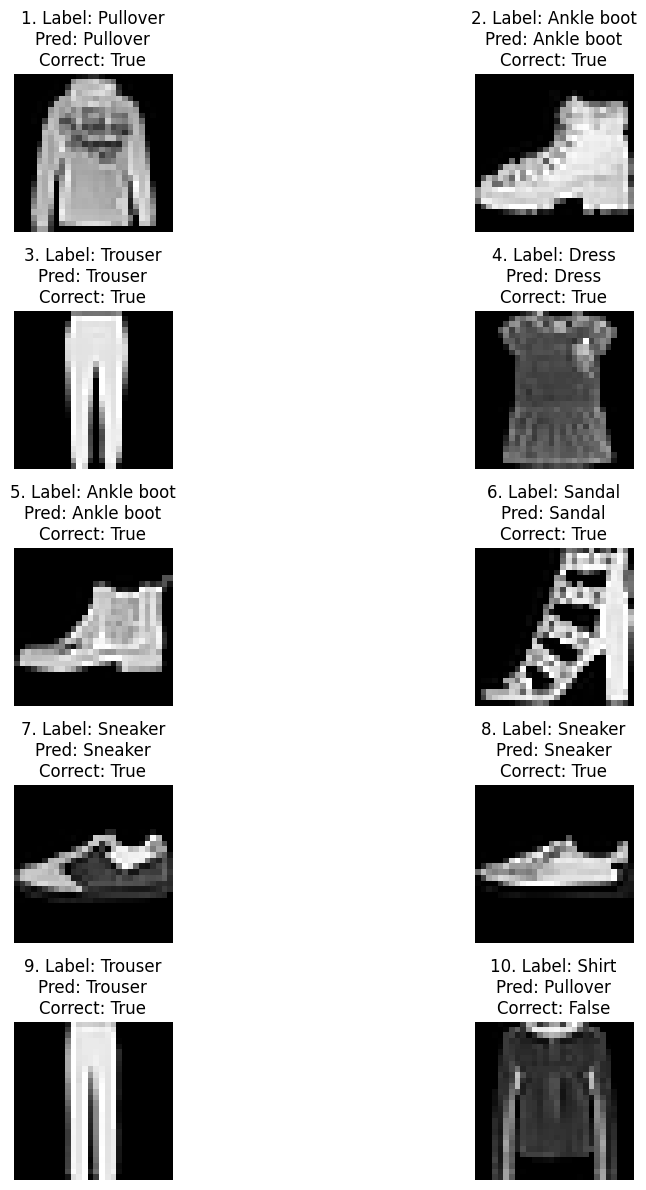

In [16]:
import matplotlib.pyplot as plt
import random

# 최소 1개 오답 확보
indices = []

# 1) 오답이 존재하면 무조건 1개 먼저 넣기
if len(wrong_indices) > 0:
    indices.append(random.choice(wrong_indices))

# 2) 나머지 9개는 전체에서 랜덤
while len(indices) < 10:
    indices.append(random.randint(0, len(test_dataset)-1))

random.shuffle(indices)

class_names = test_dataset.classes
plt.figure(figsize=(12, 12))

for i, idx in enumerate(indices):
    img, label = test_dataset[idx]

    x = transform(img).unsqueeze(0)
    pred = tester.test_single(x)

    plt.subplot(5, 2, i+1)
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.title(
        f"{i+1}. Label: {class_names[label]}\n"
        f"Pred: {class_names[pred]}\n"
        f"Correct: {label == pred}"
    )

plt.tight_layout()
plt.show()

# 분류 예측 결과가 틀린 이유 분석


[숙제 후기]